# EfficientNet-B1 Transfer Learning on CIFAR-10

This notebook demonstrates advanced transfer learning using EfficientNet-B1 with hyperparameter optimization and fine-tuning for CIFAR-10 classification.

In [93]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import ParameterSampler
from torch.amp import autocast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10

## 1. Hyperparameter Configuration

Define the hyperparameter search space for random search optimization of the classifier head.

In [94]:
# Hyperparameter search space for classifier optimization
param_distributions = {
    'learning_rate': [0.01, 0.005, 0.001, 0.0005],
    'weight_decay': [0, 1e-4, 5e-4, 1e-2, 5e-2],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'optimizer': ['adamw', 'sgd'],
    'scheduler': ['cosine', 'step', 'exponential'],
    'classifier_type': ['simple','deep']
    
}

num_trials = 20  # Increased for better optimization
batch_size = 128  # Fixed batch size for consistency
num_epochs = 20  # Final training epochs

## 2. Model Architecture

Define the EfficientNet-B1 model with customizable classifier heads for transfer learning.

In [ ]:
# Function to create model with frozen backbone and tunable classifier
def create_model_with_params(dropout_rate=0.0, freeze_backbone=True, classifier_type='deep', use_qat=False):
    model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)

    if freeze_backbone:
        # Freeze all layers except classifier
        for param in model.parameters():
            param.requires_grad = False

    # Replace classifier with tunable head
    if classifier_type == 'simple':
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(256, num_classes)
        )
    elif classifier_type == 'deep':
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(model.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    # Unfreeze classifier parameters
    for param in model.classifier.parameters():
        param.requires_grad = True

    if use_qat:
        model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        torch.prepare_qat(model, inplace=True)

    return model

# Function to create optimizer and scheduler
def create_optimizer_scheduler(model, optimizer_name, lr, weight_decay, scheduler_name, steps_per_epoch=None):
    
    if optimizer_name == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    if scheduler_name == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif scheduler_name == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif scheduler_name == 'exponential':
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    return optimizer, scheduler

# Hyperparameter tuning function for classifier optimization
def hyperparameter_tuning(train_dataset, val_dataset, param_distributions, num_trials, device):
    best_accuracy = 0
    best_params = None
    results = []

    # Sample hyperparameters
    param_list = list(ParameterSampler(param_distributions, n_iter=num_trials, random_state=42))

    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{num_trials}")
        print(f"Parameters: {params}")

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

        # Create model with frozen backbone
        model = create_model_with_params(params['dropout_rate'], freeze_backbone=True, classifier_type=params['classifier_type'])
        model = model.to(device)

        # Create optimizer and scheduler (only for classifier parameters)
        optimizer, scheduler = create_optimizer_scheduler(
            model, params['optimizer'], params['learning_rate'],
            params['weight_decay'], params['scheduler'], steps_per_epoch=len(train_loader)
        )

        criterion = nn.CrossEntropyLoss()

        # Quick training for hyperparameter evaluation (3 epochs)
        train_losses, train_accuracies, val_losses, val_accuracies, _ = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=3, device=device, use_amp=True
        )

        # Evaluate on validation set
        val_accuracy, _ = evaluate_model(model, val_loader, device)

        results.append({
            'params': params,
            'val_accuracy': val_accuracy,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        })

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params

    return best_params, best_accuracy, results

# Training function with validation and learning rate monitoring
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, fine_tune_backbone=False, patience=10, use_amp=False):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []  # Track learning rates

    scaler = torch.amp.GradScaler() if use_amp and device.type == 'cuda' else None

    best_val_acc = -float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            with autocast('cuda', enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            if use_amp and scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Step the scheduler
        if scheduler:
            scheduler.step()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Track learning rates (for monitoring fine-tuning)
        if fine_tune_backbone and hasattr(optimizer, 'param_groups'):
            current_lrs = [group['lr'] for group in optimizer.param_groups]
            learning_rates.append(current_lrs)
            if epoch == 0 or epoch == num_epochs - 1:
                # print learning rates of backbone and classifier
                print(f"Epoch {epoch+1} LRs: Backbone={current_lrs[0]:.6f}, Classifier={current_lrs[1]:.6f}")
        else:
            learning_rates.append([optimizer.param_groups[0]['lr']])

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast('cuda', enabled=use_amp):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        # Early stopping check
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            start_time = time.time()
            outputs = model(inputs)
            inference_time = time.time() - start_time
            inference_times.append(inference_time / inputs.size(0))  # Per sample

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    avg_inference_time = np.mean(inference_times) * 1000  # Convert to milliseconds

    return accuracy, avg_inference_time

# Function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 3. Hyperparameter Tuning

Perform random search hyperparameter optimization on the classifier head with frozen backbone.

In [96]:
# Enhanced Data transforms with advanced augmentation and proper resizing for EfficientNet
transform_train = transforms.Compose([
    transforms.Resize(256),  # Resize to 256 first
    transforms.RandomCrop(224),  # Then crop to 224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 normalization
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
full_train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)

# Split training data into train and validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# Perform hyperparameter tuning on classifier
print("Starting hyperparameter tuning for classifier optimization...")
best_params, best_accuracy, tuning_results = hyperparameter_tuning(
    train_dataset, val_dataset, param_distributions, num_trials, device
)

print(f"\nBest hyperparameters found: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# Train final model with best parameters (full training)
print("\nTraining final model with best hyperparameters...")
final_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
final_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
final_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Option to fine-tune backbone with reduced learning rate
fine_tune_backbone = True  # Set to True to fine-tune backbone with reduced LR
backbone_lr_multiplier = 0.1  # Backbone learning rate = classifier_lr * multiplier

if fine_tune_backbone:
    final_model = create_model_with_params(best_params['dropout_rate'], freeze_backbone=False)

    # Use different learning rates for backbone and classifier
    backbone_lr = best_params['learning_rate'] * backbone_lr_multiplier
    classifier_lr = best_params['learning_rate']

    backbone_params = [p for name, p in final_model.named_parameters() if 'classifier' not in name]
    classifier_params = list(final_model.classifier.parameters())

    if best_params['optimizer'] == 'adamw':
        final_optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': backbone_lr, 'weight_decay': best_params['weight_decay']},
            {'params': classifier_params, 'lr': classifier_lr, 'weight_decay': best_params['weight_decay']}
        ])
    else:  # sgd
        final_optimizer = optim.SGD([
            {'params': backbone_params, 'lr': backbone_lr, 'momentum': 0.9, 'weight_decay': best_params['weight_decay']},
            {'params': classifier_params, 'lr': classifier_lr, 'momentum': 0.9, 'weight_decay': best_params['weight_decay']}
        ])

    # Create scheduler that handles parameter groups
    if best_params['scheduler'] == 'cosine':
        final_scheduler = optim.lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=num_epochs)
    elif best_params['scheduler'] == 'step':
        final_scheduler = optim.lr_scheduler.StepLR(final_optimizer, step_size=5, gamma=0.5)
    elif best_params['scheduler'] == 'exponential':
        final_scheduler = optim.lr_scheduler.ExponentialLR(final_optimizer, gamma=0.9)

        
# If not fine-tuning, train only classifier head
else:
    final_model = create_model_with_params(best_params['dropout_rate'], freeze_backbone=True)
    final_optimizer, final_scheduler = create_optimizer_scheduler(
        final_model, best_params['optimizer'], best_params['learning_rate'],
        best_params['weight_decay'], best_params['scheduler']
    )

final_model = final_model.to(device)
criterion = nn.CrossEntropyLoss()

# Train final model for 20 epochs
final_train_losses, final_train_accuracies, final_val_losses, final_val_accuracies, learning_rates = train_model(
    final_model, final_train_loader, final_val_loader, criterion, final_optimizer, final_scheduler, num_epochs, device, fine_tune_backbone, patience=10, use_amp=True
)

# Evaluate on test set
final_test_accuracy, final_inference_time = evaluate_model(final_model, final_test_loader, device)

print(f"\nFinal Results:")
print(f"Train Accuracy: {final_train_accuracies[-1]:.2f}%")
print(f"Validation Accuracy: {final_val_accuracies[-1]:.2f}%")
print(f"Test Accuracy: {final_test_accuracy:.2f}%")
print(f"Inference Time: {final_inference_time:.4f} ms per sample")
print(f"Parameters: {count_parameters(final_model):,}")

Starting hyperparameter tuning for classifier optimization...

Trial 1/20
Parameters: {'weight_decay': 0.01, 'scheduler': 'step', 'optimizer': 'adamw', 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'classifier_type': 'deep'}
Epoch 1/3: Train Loss: 1.6411, Train Acc: 41.77%, Val Loss: 1.2707, Val Acc: 56.75%
Epoch 2/3: Train Loss: 1.4243, Train Acc: 49.84%, Val Loss: 1.2012, Val Acc: 58.93%
Epoch 3/3: Train Loss: 1.3923, Train Acc: 50.66%, Val Loss: 1.1587, Val Acc: 60.07%
Trial 1 Validation Accuracy: 59.81%

Trial 2/20
Parameters: {'weight_decay': 0, 'scheduler': 'exponential', 'optimizer': 'sgd', 'learning_rate': 0.01, 'dropout_rate': 0.3, 'classifier_type': 'deep'}
Epoch 1/3: Train Loss: 1.9467, Train Acc: 30.28%, Val Loss: 1.3965, Val Acc: 51.93%
Epoch 2/3: Train Loss: 1.4507, Train Acc: 48.52%, Val Loss: 1.2298, Val Acc: 57.33%
Epoch 3/3: Train Loss: 1.3557, Train Acc: 52.52%, Val Loss: 1.1772, Val Acc: 59.46%
Trial 2 Validation Accuracy: 59.46%

Trial 3/20
Parameters: {'weight_dec

## 4. Final Training and Evaluation

Train the best hyperparameter configuration with optional backbone fine-tuning and evaluate performance.

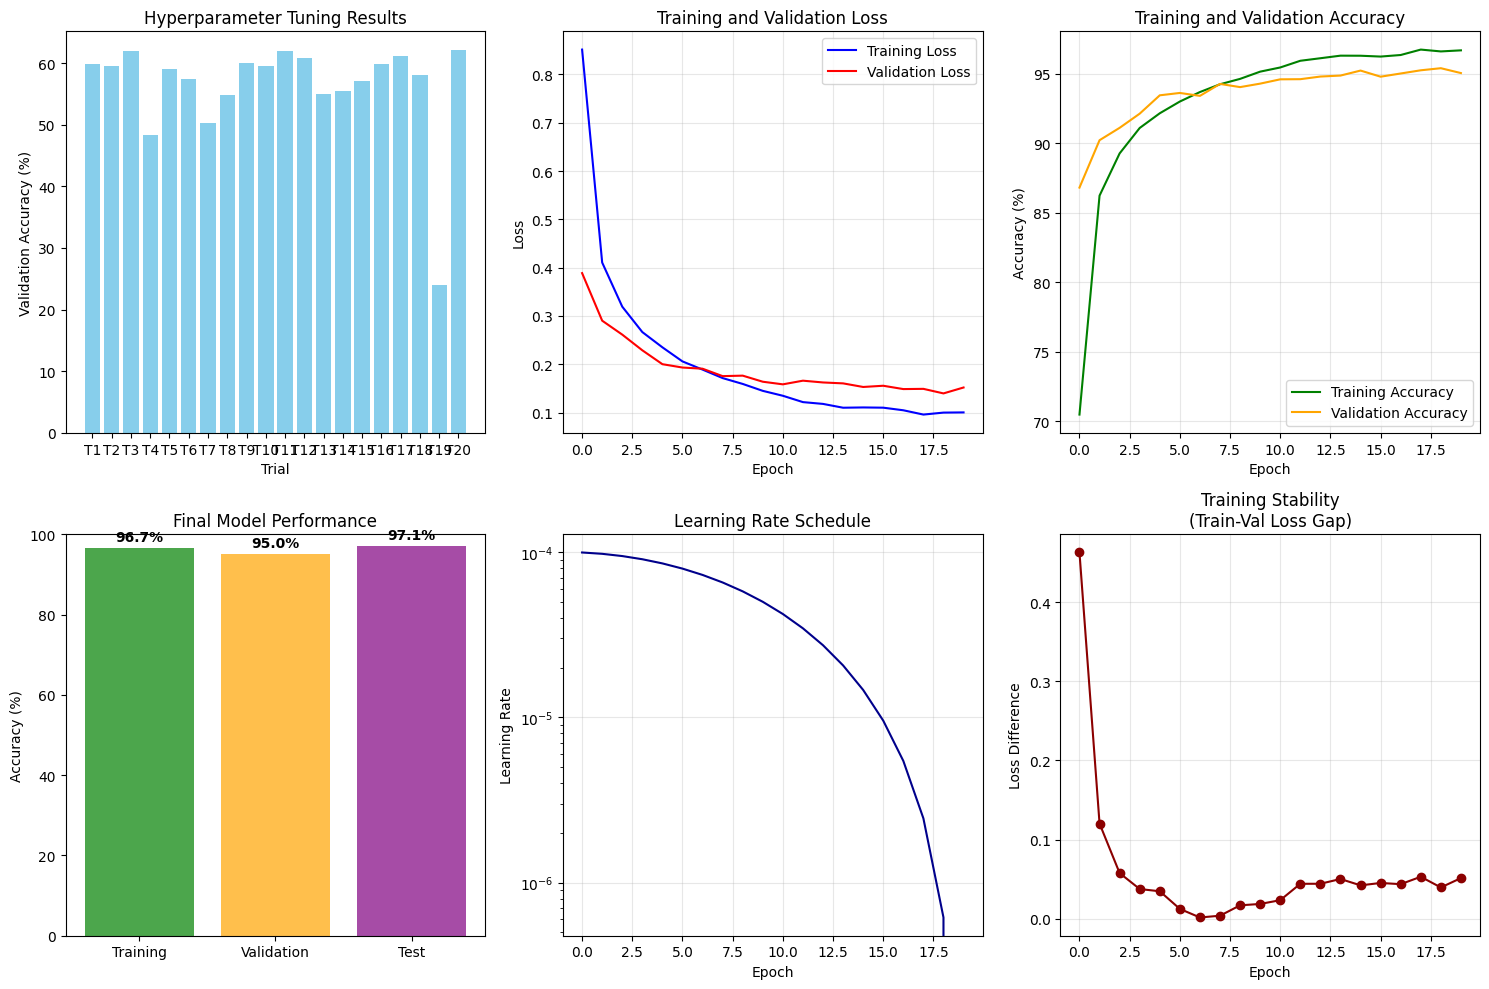


Best Hyperparameters:
weight_decay: 0.01
scheduler: cosine
optimizer: adamw
learning_rate: 0.001
dropout_rate: 0.4
classifier_type: simple


In [97]:
# Model Evaluation Plots
plt.figure(figsize=(15, 10))

# Plot 1: Hyperparameter tuning results
plt.subplot(2, 3, 1)
val_accuracies = [result['val_accuracy'] for result in tuning_results]
plt.bar(range(len(val_accuracies)), val_accuracies, color='skyblue')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy (%)')
plt.title('Hyperparameter Tuning Results')
plt.xticks(range(len(val_accuracies)), [f'T{i+1}' for i in range(len(val_accuracies))])

# Plot 2: Training and Validation Loss
plt.subplot(2, 3, 2)
plt.plot(final_train_losses, label='Training Loss', color='blue')
plt.plot(final_val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Training and Validation Accuracy
plt.subplot(2, 3, 3)
plt.plot(final_train_accuracies, label='Training Accuracy', color='green')
plt.plot(final_val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Final Performance Comparison
plt.subplot(2, 3, 4)
datasets = ['Training', 'Validation', 'Test']
accuracies = [final_train_accuracies[-1], final_val_accuracies[-1], final_test_accuracy]
colors = ['green', 'orange', 'purple']
bars = plt.bar(datasets, accuracies, color=colors, alpha=0.7)
plt.ylabel('Accuracy (%)')
plt.title('Final Model Performance')
plt.ylim([0, 100])

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 5: Learning Rate Schedule
plt.subplot(2, 3, 5)
plt.plot([lr[0] for lr in learning_rates], color='darkblue')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Plot 6: Training Stability
plt.subplot(2, 3, 6)
loss_diffs = [abs(train - val) for train, val in zip(final_train_losses, final_val_losses)]
plt.plot(loss_diffs, color='darkred', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.title('Training Stability\n(Train-Val Loss Gap)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display best hyperparameters
print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")